# State Estimation

In [1]:
import numpy as np

import sox.battery.protocol as protocol
from sox.system import IsothermalThevenin
from sox.battery import Thevenin, default_thevenin_inputs
from sox.sensor import Sensor, Normal, StuckAt, Drift
from sox.filter import CoulombCount, ExtendedKalmanFilter, UnscentedKalmanFilter, MerweSigmaPoints
from sox.utils import quick_plot

# Synthetic Ground-truth Data

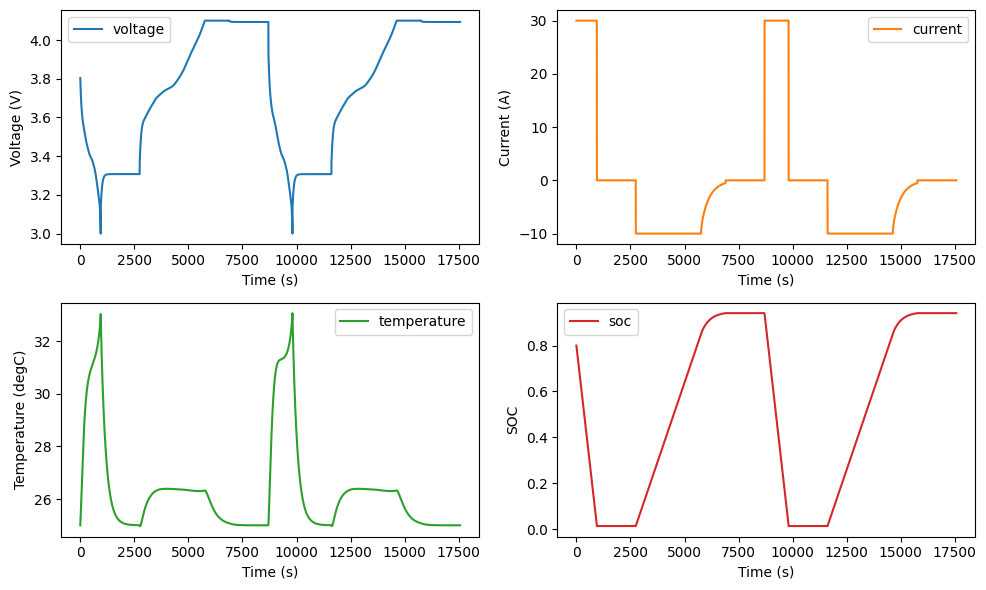

In [2]:
battery = Thevenin(default_thevenin_inputs)

dt = 1.0
solution = battery.solve(
    protocol.charge_discharge_cycling(
        chg_c_rate=1.0,
        dchg_c_rate=3.0,
        number_of_cycles=2,
        min_dchg_voltage=3.0,
        sampling_time_s=dt,
    )
)

time = solution.time
voltage = solution.voltage
current = solution.current
soc = solution.soc
cell_temperature = solution.cell_temperature

quick_plot(
    time=time,
    data=[voltage, current, cell_temperature, soc],
    legend=["voltage", "current", "temperature", "soc"],
    x_label="Time (s)",
    y_label=["Voltage (V)", "Current (A)", "Temperature (degC)", "SOC"],
)

# State Estimators

In [3]:
# sets up the coulomb counter

capacity = 10  # real value: 10
initial_soc = 0.75  # real value: 0.8
soc_with_coulomb_count = CoulombCount(initial_soc, capacity, dt)


# sets up the extended kalman filter
# assumes time-invariant model parameters and state transition

# rc_pairs = 1  # real value: 1
# capacity = 10  # real value: 10
# initial_soc = 0.75  # real value: 0.8
# ocv_func = default_thevenin_inputs.open_circuit_voltage
# r0 = 4e-3  # real value: variable
# r1 = 7e-3  # real value: variable
# c1 = 8e3  # real value: variable
# a1 = np.exp(-dt / (r1 * c1))

system = IsothermalThevenin(
    ocv_func=default_thevenin_inputs.open_circuit_voltage,
    series_resistance=4e-3,  # real value: variable
    rc_resistors=[7e-3],  # real value: variable
    rc_capacitors=[8e3],  # real value: variable
    capacity=10,  # real value: 10
)

ekf = ExtendedKalmanFilter(
    F=system.F(dt),  # state transition matrix
    B=system.B(dt),  # input matrix
    Q=np.diag([1e-4, 1e-4]),  # process noise
    R=np.array([[1e-5]]),  # measurement noise
    x0=np.array([initial_soc, 0.0])[:, np.newaxis],  # initial states [soc, v_rc1]
    P0=np.diag([0.005, 0.02]),  # initial covariance of states
)


# sets up the unscented kalman filter

ukf = UnscentedKalmanFilter(
    Q=np.diag([1e-4, 1e-4]),
    R=np.array([[1e-5]]),
    x0=np.array([initial_soc, 0.0])[:, np.newaxis],
    P0=np.diag([0.005, 0.02]),
    sigma_gen=MerweSigmaPoints(n=2, alpha=1e-3, beta=2.0, kappa=0.0),
)

# Sensors

In [4]:
# sets up the sensors

voltage_sensor = Sensor(
    name="voltage sensor",
    time=time,
    data=voltage,
    noise=Normal(0, 0.002),
    faults=[
        StuckAt(start_time=2000, stop_time=2500, value=3.0),
        Drift(start_time=0, stop_time=12000, rate=-0.02 / 3600),
    ],
)

current_sensor = Sensor(
    name="current sensor",
    time=time,
    data=current,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=500, stop_time=1000, value=0.0),
        Drift(start_time=0, stop_time=12000, rate=-0.2 / 3600),
    ],
)

temperature_sensor = Sensor(
    name="temperature sensor",
    time=time,
    data=cell_temperature,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=7000, stop_time=7500, value=30),
        Drift(start_time=0, stop_time=12000, rate=0.1 / 3600),
    ],
)

sensors = [voltage_sensor, current_sensor, temperature_sensor]

# Run Estimation

In [5]:
# runs the state estimation

v_sense = []
curr_sense = []
temp_sense = []
soc_cc = []
soc_ekf, soc_ekf_std = [], []
soc_ukf, soc_ukf_std = [], []

try:
    for s in sensors:
        s.reset()
    while True:
        # sensor readings
        voltage_reading, current_reading, temperature_reading = [s.read() for s in sensors]

        # coulomb counting
        soc_with_coulomb_count.update(current_reading)

        # extended kalman filter
        ekf.predict(u=np.array([[current_reading]]))
        ekf.update(
            z=voltage_reading,
            hx=system.hx,
            hx_args=current_reading,
            h_jacobian=system.h_jacobian,
        )

        ukf.predict(fx=system.fx, fx_args=(current_reading, dt))
        ukf.update(
            z=voltage_reading,
            hx=system.hx,
            hx_args=current_reading,
        )

        # store states and sensor readings
        soc_cc.append(soc_with_coulomb_count.soc)

        soc_ekf.append(ekf.x[0, 0])
        soc_ekf_std.append(np.sqrt(ekf.P[0, 0]))

        soc_ukf.append(ukf.x[0, 0])
        soc_ukf_std.append(np.sqrt(ukf.P[0, 0]))

        v_sense.append(voltage_reading)
        curr_sense.append(current_reading)
        temp_sense.append(temperature_reading)

except Exception as e:
    print(e)

Sensor 'voltage sensor' finished reading.


IndexError: Sensor 'voltage sensor' finished reading.

# Plot Results

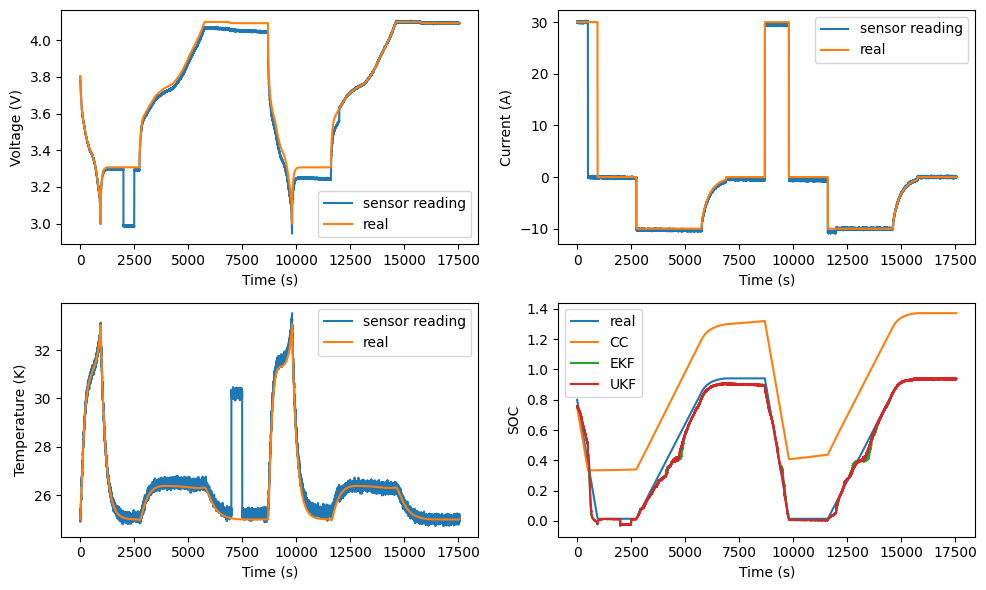

In [8]:
quick_plot(
    time=time,
    data=[[v_sense, voltage], [curr_sense, current], [temp_sense, cell_temperature], [soc, soc_cc, soc_ekf, soc_ukf]],
    legend=[
        ["sensor reading", "real"],
        ["sensor reading", "real"],
        ["sensor reading", "real"],
        ["real", "CC", "EKF", "UKF"],
    ],
    x_label="Time (s)",
    y_label=["Voltage (V)", "Current (A)", "Temperature (K)", "SOC"],
)

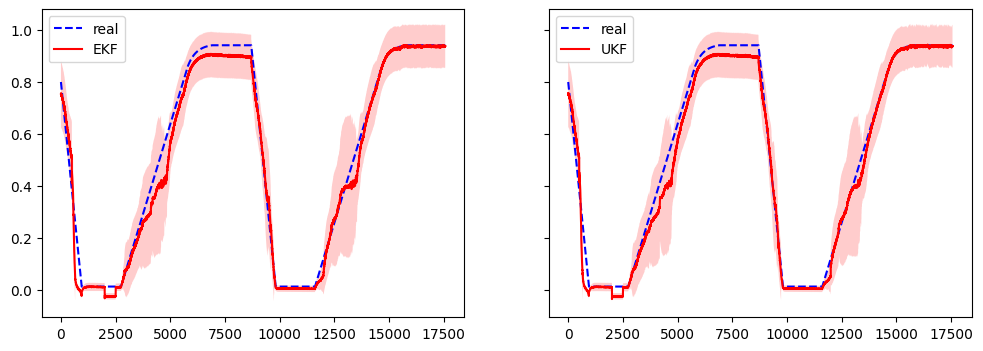

In [7]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

ax1.plot(time, soc, "--b", label="real")
ax1.plot(time, soc_ekf, "r", label="EKF")
ax1.fill_between(
    time,
    np.array(soc_ekf) - 2 * np.array(soc_ekf_std),
    np.array(soc_ekf) + 2 * np.array(soc_ekf_std),
    facecolor="r",
    alpha=0.2,
)
ax1.legend()

ax2.plot(time, soc, "--b", label="real")
ax2.plot(time, soc_ukf, "r", label="UKF")
ax2.fill_between(
    time,
    np.array(soc_ukf) - 2 * np.array(soc_ukf_std),
    np.array(soc_ukf) + 2 * np.array(soc_ukf_std),
    facecolor="r",
    alpha=0.2,
)
ax2.legend()

plt.show()